# Overview

This notebook will highlight the core process, train, and deploy functionality from Amazon SageMaker

For this example we'll use a tabular dataset for classification.  This dataset contains observations from the Roosevelt National Forest in Colorado.  Predicting forest cover type from cartographic variables only (no remotely sensed data). The actual forest cover type for a given observation (30 x 30 meter cell) was determined from US Forest Service (USFS) Region 2 Resource Information System (RIS) data. Independent variables were derived from data originally obtained from US Geological Survey (USGS) and USFS data. Data is in raw form (not scaled) and contains binary (0 or 1) columns of data for qualitative independent variables (wilderness areas and soil types). 

The classification task is - given attributes of the land, can you predict the forest cover type?

### Install 

In [1]:
!pip install -r requirements.txt

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


### Setup

In [2]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import boto3
import re
import sagemaker
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.debugger import Rule, rule_configs
import seaborn as sns
from sklearn.metrics import confusion_matrix
from IPython.display import display, clear_output

plt.rcParams['axes.axisbelow'] = True

In [3]:
# setup
sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = 'demo_cover_type'
role = sagemaker.get_execution_role()

print(f'IAM role :  {role}')
print(f'S3 Bucket:  {bucket}')
print(f'S3 Prefix:  {prefix}')

IAM role :  arn:aws:iam::431615879134:role/sagemaker-test-role
S3 Bucket:  sagemaker-us-east-1-431615879134
S3 Prefix:  demo_cover_type


# Data

### Explore

In [4]:
!mkdir -p data

In [5]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz

--2021-09-28 01:01:01--  https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11240707 (11M) [application/x-httpd-php]
Saving to: ‘covtype.data.gz’

covtype.data.gz     100%[===================>]  10.72M  12.8MB/s    in 0.8s    

2021-09-28 01:01:03 (12.8 MB/s) - ‘covtype.data.gz’ saved [11240707/11240707]



In [6]:
!gzip -d covtype.data.gz
!mv covtype.data ./data/covtype.data

In [7]:
header = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40', 'Cover_Type']

In [8]:
df = pd.read_csv('./data/covtype.data',names=header)

In [9]:
df

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396,153,20,85,17,108,240,237,118,837,...,0,0,0,0,0,0,0,0,0,3
581008,2391,152,19,67,12,95,240,237,119,845,...,0,0,0,0,0,0,0,0,0,3
581009,2386,159,17,60,7,90,236,241,130,854,...,0,0,0,0,0,0,0,0,0,3
581010,2384,170,15,60,5,90,230,245,143,864,...,0,0,0,0,0,0,0,0,0,3


In [10]:
classes = ['Spruce/Fir','Lodgepole Pine','Ponderosa Pine','Cottonwood/Willow','Aspen','Douglas-fir','Krummholz']

In [11]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Wilderness_Area2                    581012 non-null 

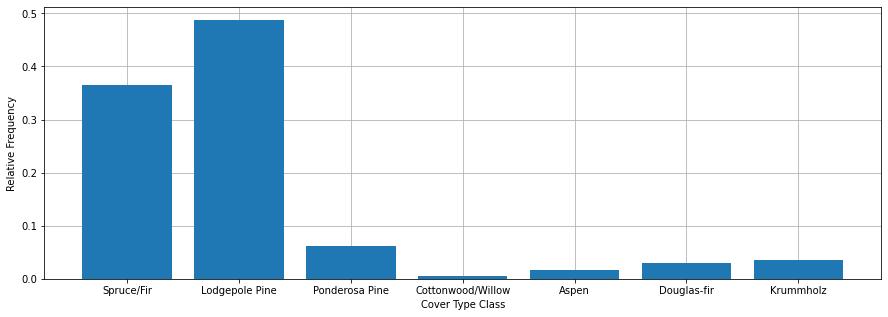

In [12]:
plt.figure(figsize=(15,5))
plt.bar(x = classes,height = df['Cover_Type'].value_counts(normalize=True,sort=False).values)
plt.grid()
plt.xlabel('Cover Type Class')
plt.ylabel('Relative Frequency');

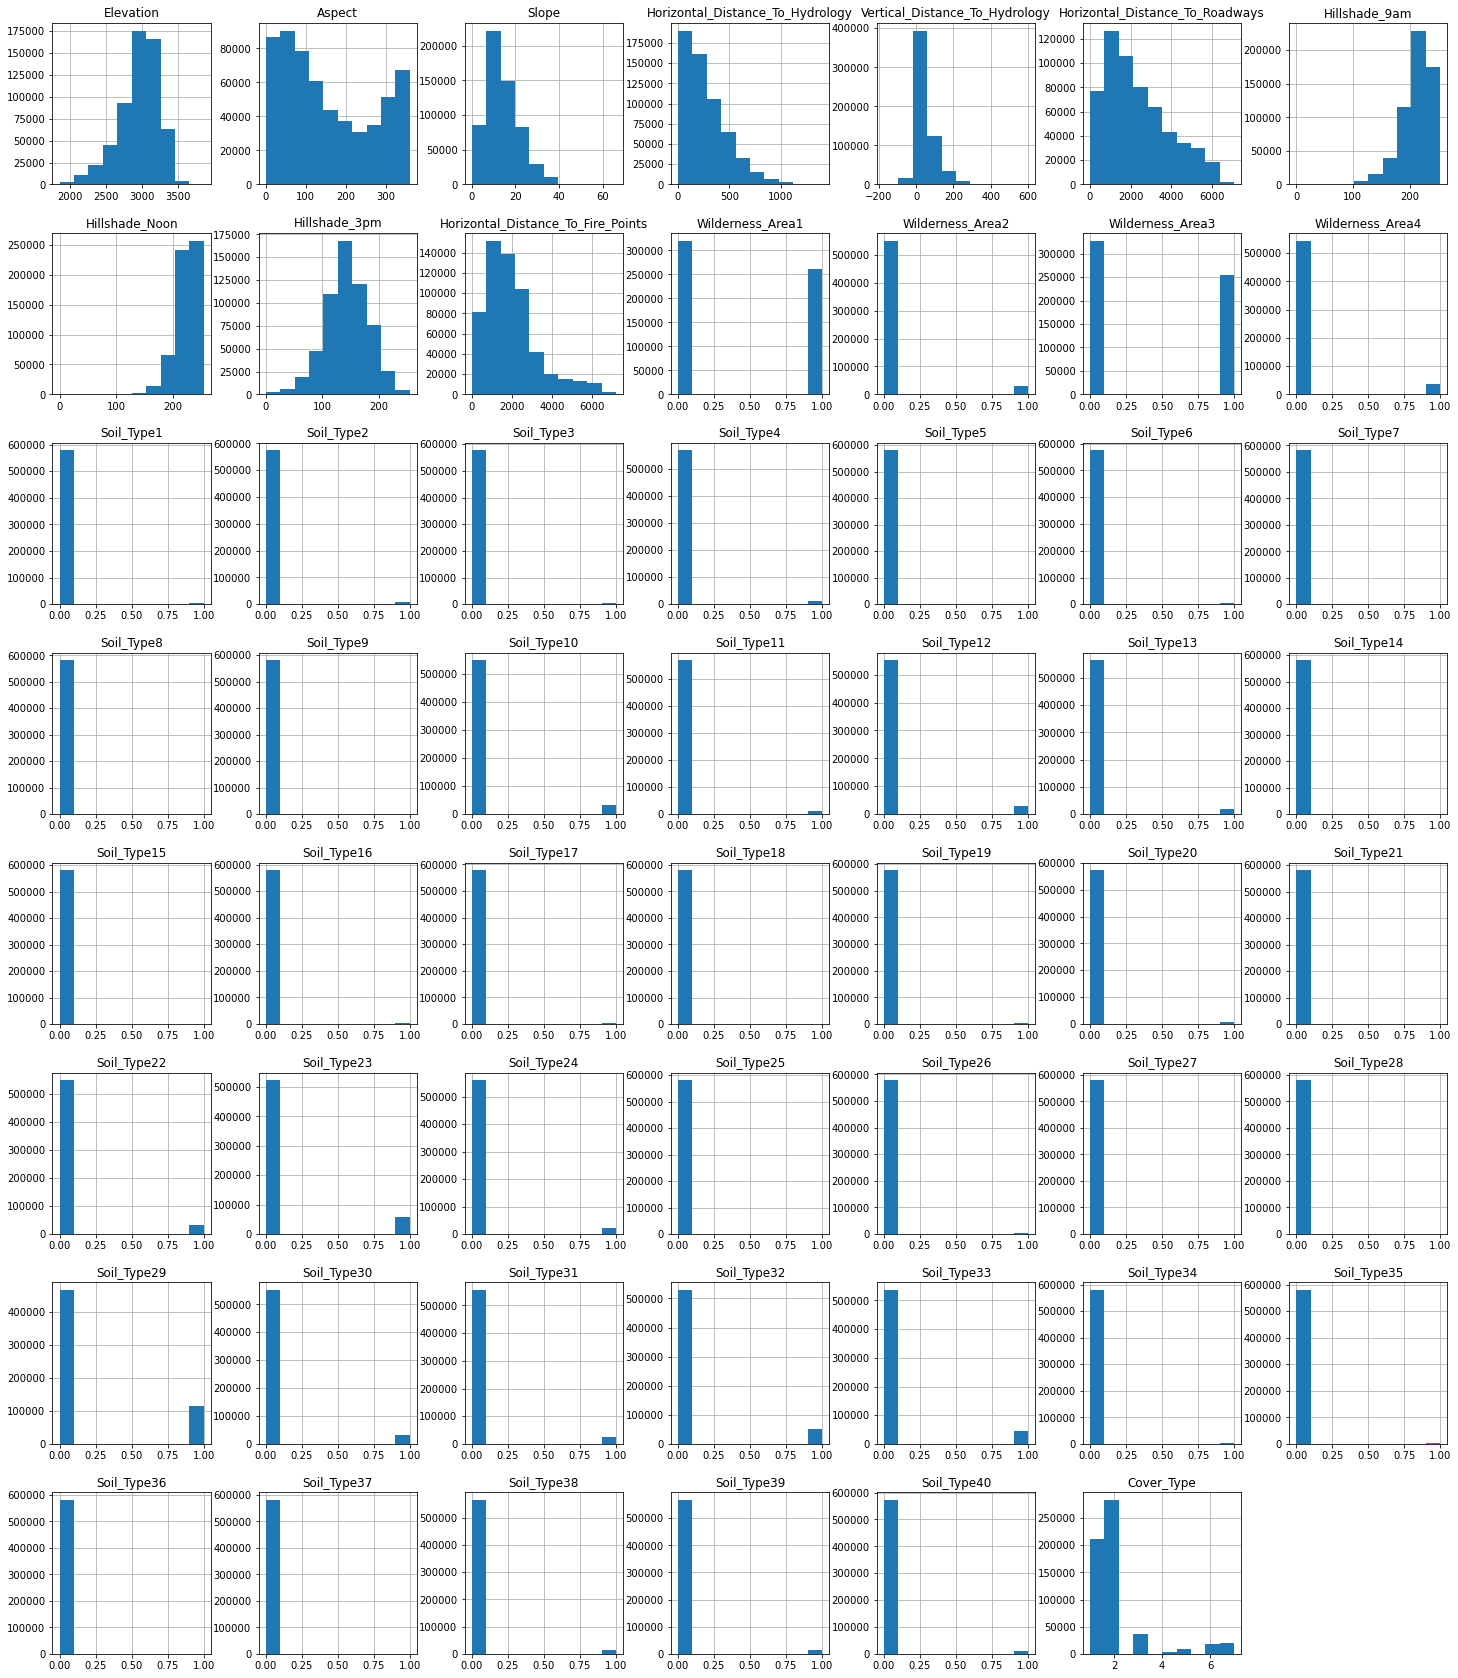

In [13]:
df.hist(figsize=(25,30));

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


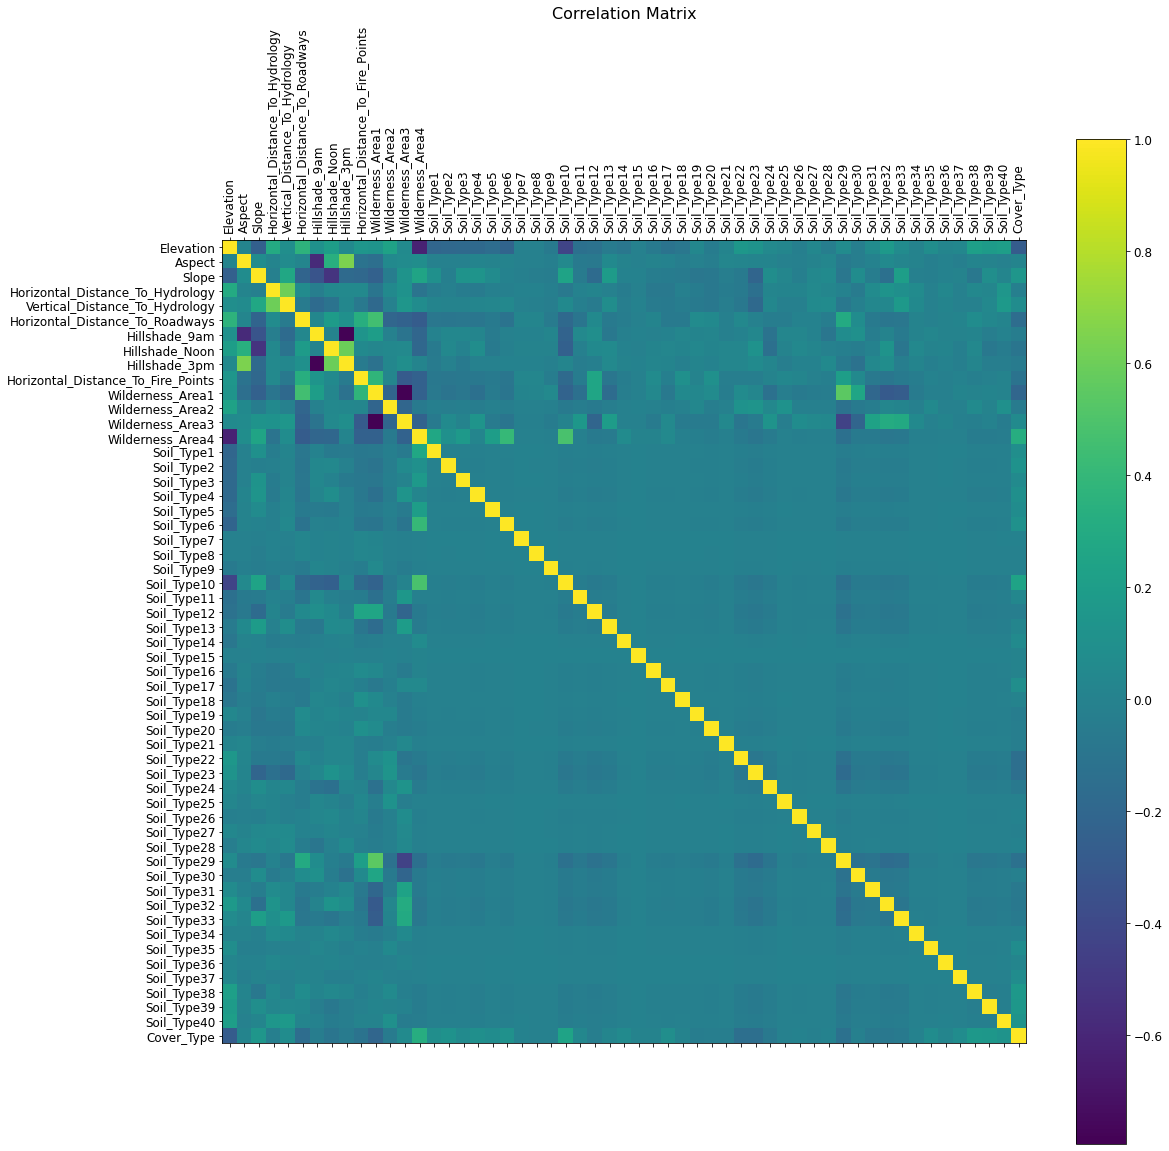

In [14]:
f = plt.figure(figsize=(18, 18))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=12, rotation=90)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=12)
cb = plt.colorbar(cmap='coolwarm')
cb.ax.tick_params(labelsize=12)
plt.title('Correlation Matrix', fontsize=16);

In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Elevation,581012.0,2959.365301,279.984734,1859.0,2809.0,2996.0,3163.0,3858.0
Aspect,581012.0,155.656807,111.913721,0.0,58.0,127.0,260.0,360.0
Slope,581012.0,14.103704,7.488242,0.0,9.0,13.0,18.0,66.0
Horizontal_Distance_To_Hydrology,581012.0,269.428217,212.549356,0.0,108.0,218.0,384.0,1397.0
Vertical_Distance_To_Hydrology,581012.0,46.418855,58.295232,-173.0,7.0,30.0,69.0,601.0
Horizontal_Distance_To_Roadways,581012.0,2350.146611,1559.254870,0.0,1106.0,1997.0,3328.0,7117.0
Hillshade_9am,581012.0,212.146049,26.769889,0.0,198.0,218.0,231.0,254.0
Hillshade_Noon,581012.0,223.318716,19.768697,0.0,213.0,226.0,237.0,254.0
Hillshade_3pm,581012.0,142.528263,38.274529,0.0,119.0,143.0,168.0,254.0
Horizontal_Distance_To_Fire_Points,581012.0,1980.291226,1324.195210,0.0,1024.0,1710.0,2550.0,7173.0


In [16]:
len(classes)

7

In [17]:
df['Cover_Type'].value_counts()

2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: Cover_Type, dtype: int64

### Upload

To use SageMaker processing and training jobs we need to upload our data to s3.  Note that this isn't the only storage location for machine learning data, EFS and FSx for Lustre are also supported.

In [18]:
rawdata = sess.upload_data('./data/covtype.data',bucket=bucket,key_prefix=prefix)
print(f'Raw data uploaded to:  {rawdata}')

Raw data uploaded to:  s3://sagemaker-us-east-1-431615879134/demo_cover_type/covtype.data


# Processing

In [19]:
sklearn_processor = SKLearnProcessor(
    framework_version='0.23-1', # sklearn version
    role=role,
    instance_type='ml.m5.xlarge',
    instance_count=1)

In [20]:
sklearn_processor.run(
    code='preprocessing.py',
    arguments = ['--val_split', '0.2',
                 '--test_split','0.1',
                 '--scaler','robust'],
    inputs=[
        ProcessingInput(input_name = 'rawdata',
                        source=rawdata,
                        destination='/opt/ml/processing/rawdata')
    ],
    outputs=[
        ProcessingOutput(output_name='train_data', 
                         source='/opt/ml/processing/train',
                         destination=f's3://{bucket}/{prefix}/'),
        ProcessingOutput(output_name='val_data', 
                         source='/opt/ml/processing/val',
                         destination=f's3://{bucket}/{prefix}/'),
        ProcessingOutput(output_name='test_data', 
                         source='/opt/ml/processing/test',
                         destination=f's3://{bucket}/{prefix}/'),
        ProcessingOutput(output_name='scaler', 
                         source='/opt/ml/processing/scaler',
                         destination=f's3://{bucket}/{prefix}/')
    ])



Job Name:  sagemaker-scikit-learn-2021-09-28-01-01-25-794
Inputs:  [{'InputName': 'rawdata', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-431615879134/demo_cover_type/covtype.data', 'LocalPath': '/opt/ml/processing/rawdata', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-431615879134/sagemaker-scikit-learn-2021-09-28-01-01-25-794/input/code/preprocessing.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'train_data', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-431615879134/demo_cover_type/', 'LocalPath': '/opt/ml/processing/train', 'S3UploadMode': 'EndOfJob'}}, {'OutputName': 'val_data', 'AppManaged': False, 'S3Output': {'S

In [21]:
preprocessing_job_description = sklearn_processor.jobs[-1].describe()
preprocessing_job_description

{'ProcessingInputs': [{'InputName': 'rawdata',
   'AppManaged': False,
   'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-431615879134/demo_cover_type/covtype.data',
    'LocalPath': '/opt/ml/processing/rawdata',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated',
    'S3CompressionType': 'None'}},
  {'InputName': 'code',
   'AppManaged': False,
   'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-431615879134/sagemaker-scikit-learn-2021-09-28-01-01-25-794/input/code/preprocessing.py',
    'LocalPath': '/opt/ml/processing/input/code',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated',
    'S3CompressionType': 'None'}}],
 'ProcessingOutputConfig': {'Outputs': [{'OutputName': 'train_data',
    'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-431615879134/demo_cover_type/',
     'LocalPath': '/opt/ml/processing/train',
     'S3UploadMode': 'EndOfJob'},
    'AppManaged': False},
   {'Out

# Training

In [22]:
container = sagemaker.image_uris.retrieve('xgboost',boto3.Session().region_name,version='1.3-1')
print(container)

683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.3-1


In [23]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data=f's3://{bucket}/{prefix}/train.csv', content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data=f's3://{bucket}/{prefix}/val.csv', content_type='csv')

In [24]:
# configure Xgboost Report
rules=[Rule.sagemaker(rule_configs.create_xgboost_report())]

In [25]:
output_path = f's3://{bucket}/{prefix}/output/'

# construct a SageMaker estimator that calls the xgboost-container
estimator = sagemaker.estimator.Estimator(image_uri=container, 
                                          role=role,
                                          instance_count=1, 
                                          instance_type='ml.m5.2xlarge', 
                                          volume_size=5, # 5 GB 
                                          output_path=output_path,
                                          rules=rules)

In [26]:
estimator.set_hyperparameters(
    objective='multi:softmax',
    num_class=len(classes),
    num_round=50,
)

In [27]:
estimator.fit({'train': s3_input_train, 'validation': s3_input_validation})

2021-09-28 01:11:42 Starting - Starting the training job...
2021-09-28 01:12:06 Starting - Launching requested ML instancesCreateXgboostReport: InProgress
ProfilerReport-1632791502: InProgress
......
2021-09-28 01:13:06 Starting - Preparing the instances for training.........
2021-09-28 01:14:40 Downloading - Downloading input data
2021-09-28 01:14:40 Training - Downloading the training image...
2021-09-28 01:15:06 Training - Training image download completed. Training in progress.[2021-09-28 01:14:57.694 ip-10-0-83-125.ec2.internal:1 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-09-28:01:14:57:INFO] Imported framework sagemaker_xgboost_container.training
[2021-09-28:01:14:57:INFO] Failed to parse hyperparameter objective value multi:softmax to Json.
Returning the value itself
[2021-09-28:01:14:57:INFO] No GPUs detected (normal if no gpus installed)
[2021-09-28:01:14:57:INFO] Running XGBoost Sagemaker in algorithm mode
[2021-09-28:01:14:57:INFO] Determined delimiter of CS

### Training Performance

In [28]:
# plot validation and training progress
client = boto3.client('logs')
BASE_LOG_NAME = '/aws/sagemaker/TrainingJobs'

def plot_log(training_job_name):
    logs = client.describe_log_streams(logGroupName=BASE_LOG_NAME, logStreamNamePrefix=training_job_name)
    cw_log = client.get_log_events(logGroupName=BASE_LOG_NAME, logStreamName=logs['logStreams'][0]['logStreamName'])
    metrics = [
        ('train-mlogloss','validation-mlogloss'),
        ]

    for metric_group in metrics:
        fig, ax = plt.subplots(figsize=(15,10))  
        val = []
        train = []
        iteration = []
        count = 0

        for e in cw_log['events']:
            msg = e['message']
            for i,metric in enumerate(metric_group):   
                restring = f"#011{metric}:([-+]?[0-9]*\.?[0-9]+(?:[eE][-+]?[0-9]+)?)"
                comp = re.compile(restring)
                temp_ = comp.search(msg)

                if temp_ is not None:
                    
                    if i==0: 
                        train.append(float(temp_.groups()[0]))
                    elif i==1: 
                        val.append(float(temp_.groups()[0]))
                        iteration.append(count)
                        count+=1
                           
        # plots
        for i,metric in enumerate(metric_group):
            if i==0: ax.plot(iteration,train,label=metric)
            elif i==1: ax.plot(iteration,val,label=metric)
            
        plt.xlabel('Round')
        plt.ylabel(metric_group[0].split('-')[-1])
        plt.title(training_job_name)
        plt.legend()
        plt.grid()
        plt.show()

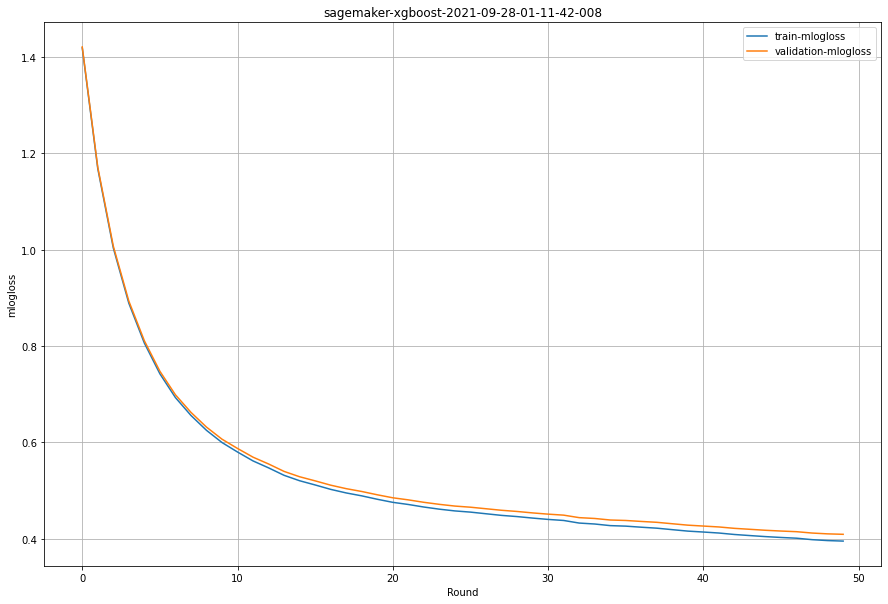

In [29]:
plot_log(estimator.latest_training_job.job_name)

# Deploy

In [30]:
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    serializer=sagemaker.serializers.CSVSerializer(),
)

---------!

In [31]:
!aws s3 cp {f's3://{bucket}/{prefix}/test.csv'} ./data/test.csv

download: s3://sagemaker-us-east-1-431615879134/demo_cover_type/test.csv to data/test.csv


In [32]:
test_df = pd.read_csv('./data/test.csv',header=None)

In [33]:
test_df

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,1,-0.447887,1.014851,0.222222,-0.481884,-0.435484,0.203146,-1.030303,-0.250000,0.653061,...,0,0,1,0,0,0,0,0,0,0
1,0,0.292958,1.113861,0.222222,-0.246377,-0.096774,0.719551,-0.757576,-0.541667,0.306122,...,0,0,0,0,0,0,0,0,0,0
2,0,0.304225,0.707921,0.333333,-0.329710,0.145161,-0.045843,-1.242424,0.750000,1.265306,...,0,0,0,0,0,0,0,0,0,0
3,1,-0.498592,-0.128713,-0.555556,-0.681159,-0.467742,-0.553708,0.454545,0.166667,-0.285714,...,0,0,0,0,0,0,0,0,0,0
4,1,0.214085,-0.316832,-1.222222,-0.398551,-0.854839,0.444494,0.090909,0.333333,0.142857,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58097,2,-2.591549,1.099010,1.777778,-0.061594,1.951613,-0.800000,-2.000000,-2.041667,0.224490,...,0,0,0,0,0,0,0,0,0,0
58098,6,0.746479,-0.554455,0.555556,1.362319,1.096774,0.315056,-0.484848,-1.041667,-0.224490,...,0,1,0,0,0,0,0,0,0,0
58099,0,-0.557746,0.673267,0.444444,-0.681159,-0.338710,-0.517303,-1.242424,0.833333,1.306122,...,0,0,0,0,0,0,0,0,0,0
58100,0,-0.030986,1.004950,0.000000,-0.681159,-0.306452,0.189663,-0.909091,-0.083333,0.653061,...,0,0,1,0,0,0,0,0,0,0


In [34]:
test_df.iloc[1,1::].values

array([ 0.29295775,  1.11386139,  0.22222222, -0.24637681, -0.09677419,
        0.71955056, -0.75757576, -0.54166667,  0.30612245,  0.69502618,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ])

In [35]:
# test endpoint with single data
predictor.predict(test_df.iloc[1,1::].values)

b'0.0'

In [36]:
# actual
test_df.iloc[10:20,0].values

array([2, 0, 2, 0, 1, 1, 0, 6, 0, 2])

In [37]:
# test endpoint with batch of data
predictor.predict(test_df.iloc[10:20,1::].values)

b'2.0,0.0,2.0,0.0,1.0,1.0,1.0,6.0,1.0,2.0'

# Evaluate

In [38]:
def predict_all(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

In [39]:
predictions = predict_all(test_df.to_numpy()[:,1:])

In [40]:
actuals = test_df.iloc[:,0].values

In [41]:
actuals.shape

(58102,)

In [42]:
predictions.shape

(58102,)

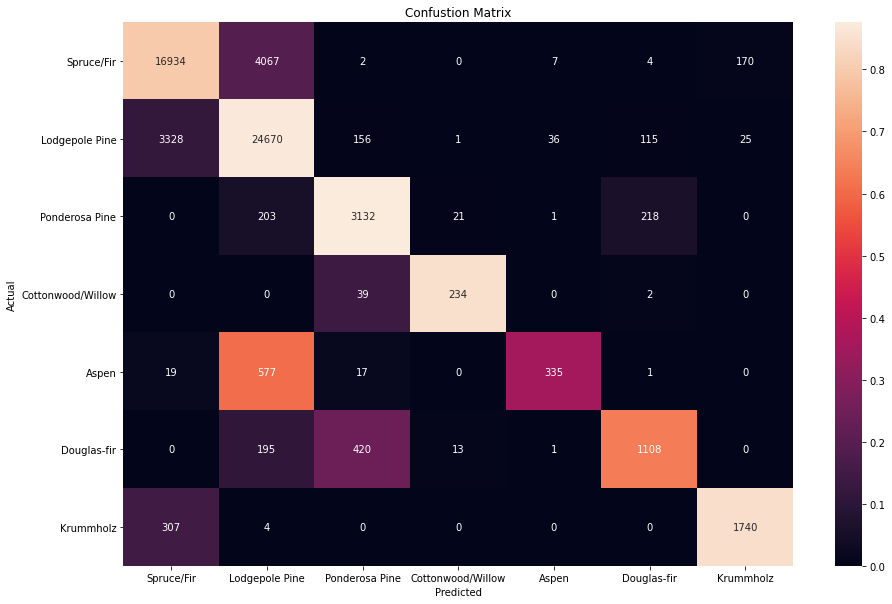

In [43]:
fig, ax = plt.subplots(figsize=(15,10))
cm = confusion_matrix(actuals,predictions)
normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, ax=ax, annot=cm, fmt='',xticklabels=classes,yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confustion Matrix')
plt.show()

# Clean Up

In [44]:
#predictor.delete_endpoint()